In [48]:
import pandas as pd
import numpy as np

sp500_data = pd.read_csv('S&P_500_data.csv')
treasury_data = pd.read_csv('10_Year_Treasury_Yield.csv')

# 选择需要的列（调整列名）
sp500_data = sp500_data[['Date', 'Close']].rename(columns={'Date': 'Date'})
treasury_data = treasury_data[['Date', '10_Year_Treasury_Yield']].rename(columns={'Date': 'Date'})

# 确保日期格式一致
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
treasury_data['Date'] = pd.to_datetime(treasury_data['Date'])

# 合并数据
merged_data = pd.merge(sp500_data, treasury_data, on='Date', how='inner')

# 查看合并结果
print(merged_data.head())

        Date      Close  10_Year_Treasury_Yield
0 1962-01-02  70.959999                    4.06
1 1962-01-03  71.129997                    4.03
2 1962-01-04  70.639999                    3.99
3 1962-01-05  69.660004                    4.02
4 1962-01-08  69.120003                    4.03


In [50]:
filtered_data = merged_data[merged_data['Date'] >= '2000-01-01']

In [52]:
filtered_data.head(), filtered_data['Date'].min()

(           Date        Close  10_Year_Treasury_Yield
 9569 2000-01-03  1455.219971                    6.58
 9570 2000-01-04  1399.420044                    6.49
 9571 2000-01-05  1402.109985                    6.62
 9572 2000-01-06  1403.449951                    6.57
 9573 2000-01-07  1441.469971                    6.52,
 Timestamp('2000-01-03 00:00:00'))

In [54]:
# 只对数值列进行描述性统计
numeric_stats = filtered_data[['Close', '10_Year_Treasury_Yield']].describe()

# 输出描述性统计结果
print("数值列描述性统计：")
print(numeric_stats)

# 补充时间范围信息
date_range = (filtered_data['Date'].min(), filtered_data['Date'].max())
print("\n时间范围：", date_range)

数值列描述性统计：
             Close  10_Year_Treasury_Yield
count  6267.000000             6221.000000
mean   2098.323887                3.279328
std    1223.785426                1.306452
min     676.530029                0.520000
25%    1200.074951                2.200000
50%    1486.000000                3.290000
75%    2740.530029                4.270000
max    6021.629883                6.790000

时间范围： (Timestamp('2000-01-03 00:00:00'), Timestamp('2024-11-27 00:00:00'))


In [56]:
# 按月聚合数据，取每月最后一个交易日的数据
filtered_data.set_index('Date', inplace=True)
monthly_data = filtered_data.resample('M').last()

# 计算每月收益率
monthly_data['Stock_Monthly_Return'] = monthly_data['Close'].pct_change().apply(lambda x: np.log(1 + x))
monthly_data['Bond_Monthly_Return'] = monthly_data['10_Year_Treasury_Yield'].pct_change().apply(lambda x: np.log(1 + x))

# 查看结果
monthly_data[['Stock_Monthly_Return', 'Bond_Monthly_Return']].head()

/var/folders/c5/kdmgjn_d3zg1j_6yj1tpg5ph0000gn/T/ipykernel_18962/4243368026.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = filtered_data.resample('M').last()


,Stock_Monthly_Return,Bond_Monthly_Return
Date,,
2000-01-31,NaN,NaN
2000-02-29,-0.020313,-0.039700
2000-03-31,0.092324,-0.062671
2000-04-30,-0.031280,0.032629
2000-05-31,-0.022159,0.009585


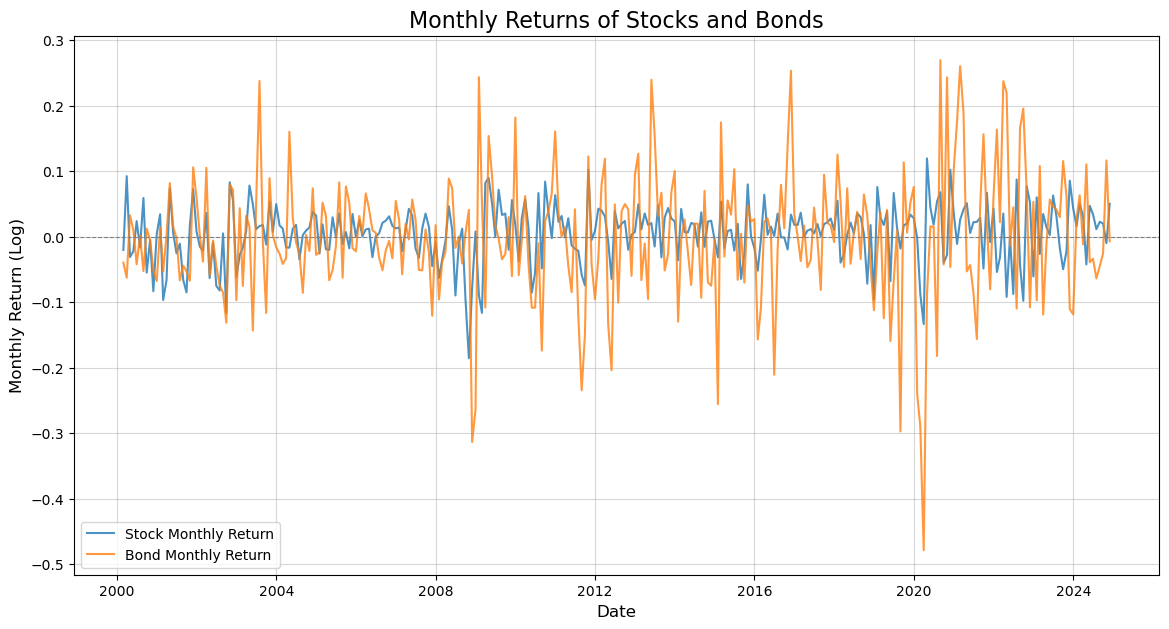

In [58]:
import matplotlib.pyplot as plt

# 可视化月收益率
plt.figure(figsize=(14, 7))

# 绘制股票月收益率
plt.plot(monthly_data.index, monthly_data['Stock_Monthly_Return'], label='Stock Monthly Return', alpha=0.8)

# 绘制债券月收益率
plt.plot(monthly_data.index, monthly_data['Bond_Monthly_Return'], label='Bond Monthly Return', alpha=0.8)

# 图表美化
plt.title('Monthly Returns of Stocks and Bonds', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Monthly Return (Log)', fontsize=12)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.legend()
plt.grid(alpha=0.5)
plt.show()

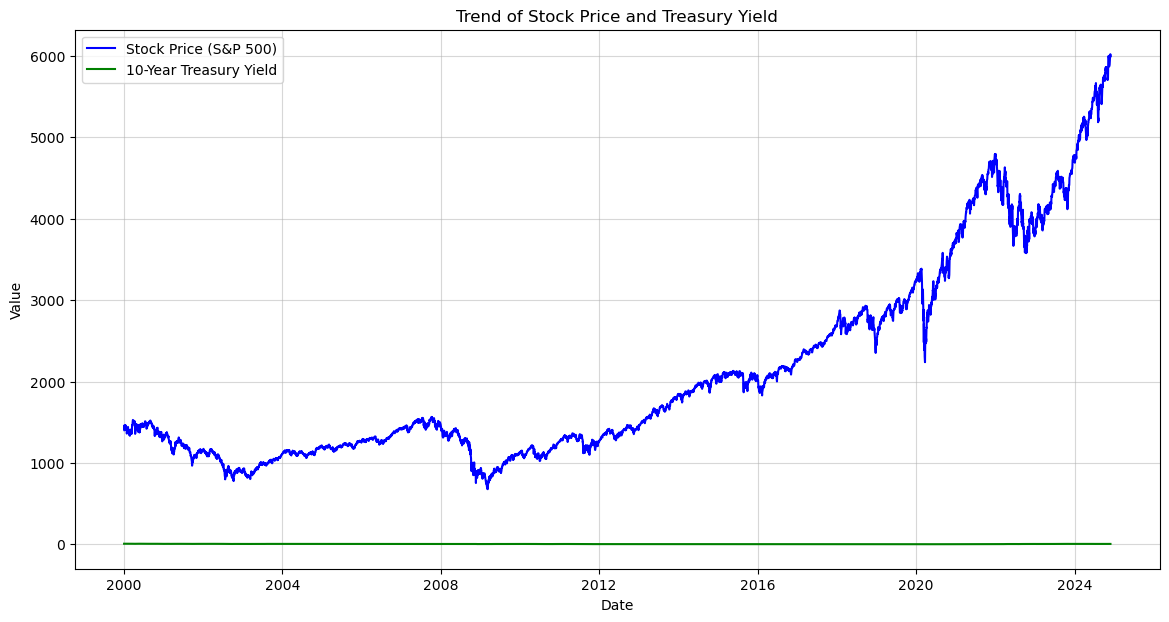

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 时间序列可视化
plt.figure(figsize=(14, 7))
sns.lineplot(data=filtered_data, x=filtered_data.index, y='Close', label='Stock Price (S&P 500)', color='blue')
sns.lineplot(data=filtered_data, x=filtered_data.index, y='10_Year_Treasury_Yield', label='10-Year Treasury Yield', color='green')
plt.title('Trend of Stock Price and Treasury Yield')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(alpha=0.5)
plt.show()


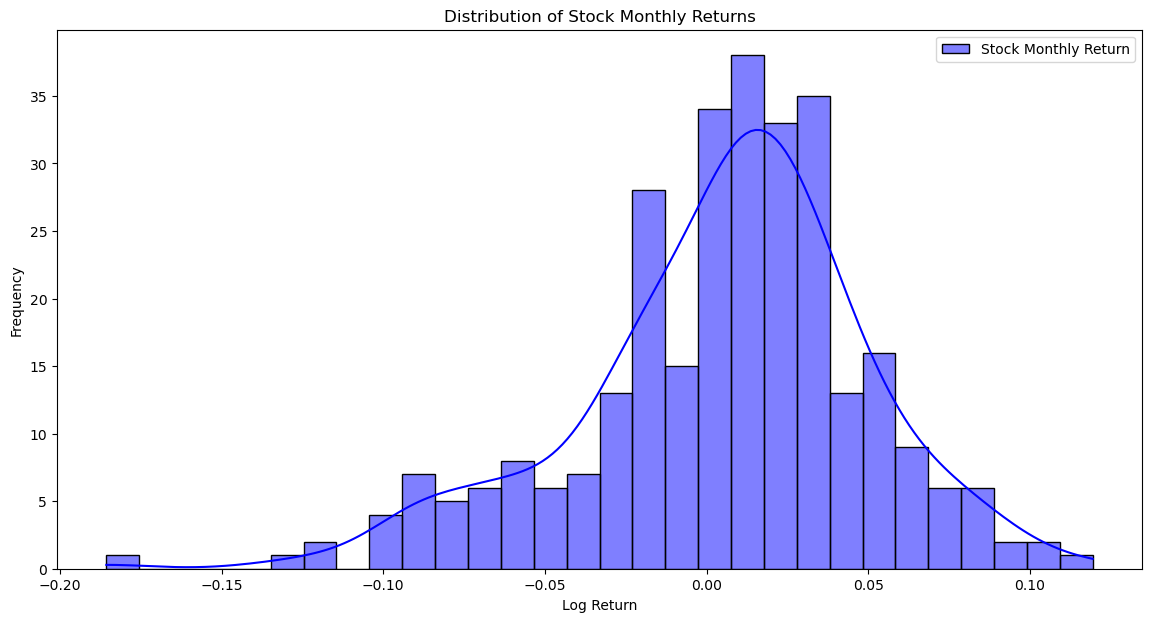

In [62]:
# 2. 分布分析 - 股票收益率的分布
plt.figure(figsize=(14, 7))
sns.histplot(monthly_data['Stock_Monthly_Return'], kde=True, bins=30, label='Stock Monthly Return', color='blue')
plt.title('Distribution of Stock Monthly Returns')
plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()

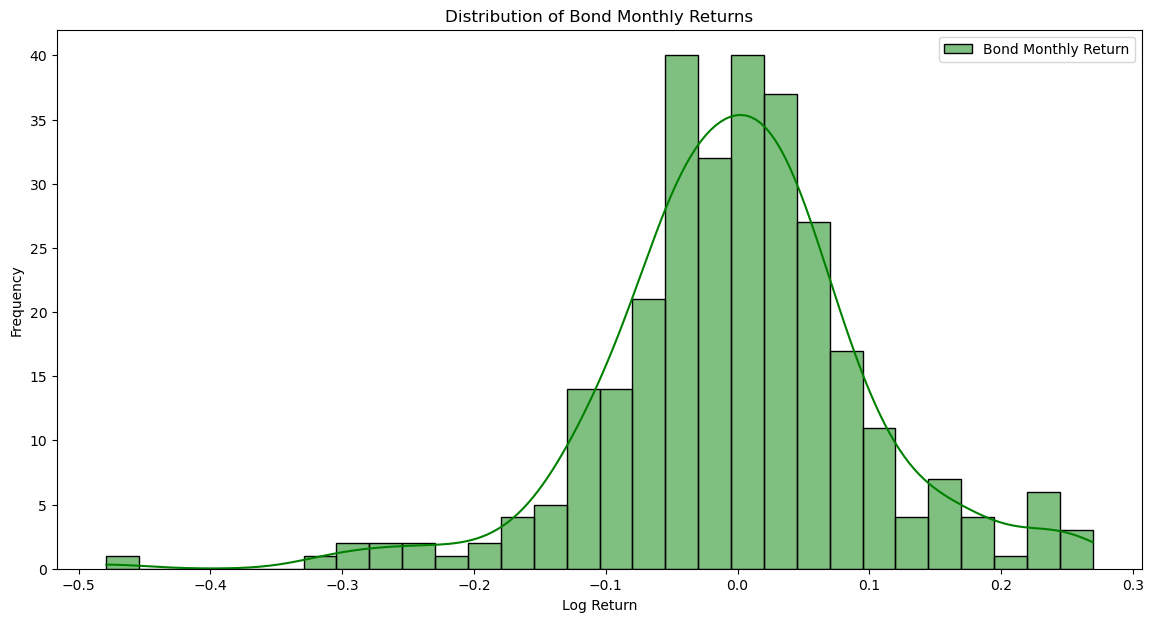

In [64]:
# 分布分析 - 债券收益率的分布
plt.figure(figsize=(14, 7))
sns.histplot(monthly_data['Bond_Monthly_Return'], kde=True, bins=30, label='Bond Monthly Return', color='green')
plt.title('Distribution of Bond Monthly Returns')
plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()

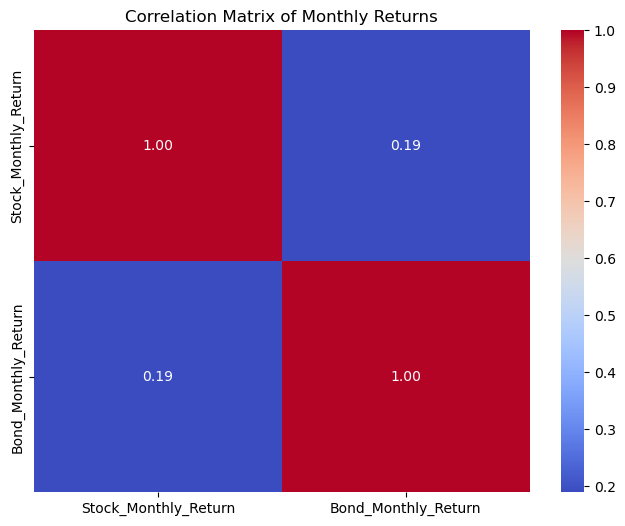

In [66]:
# 3. 相关性分析 - 计算相关性矩阵并可视化
correlation_matrix = monthly_data[['Stock_Monthly_Return', 'Bond_Monthly_Return']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix of Monthly Returns')
plt.show()

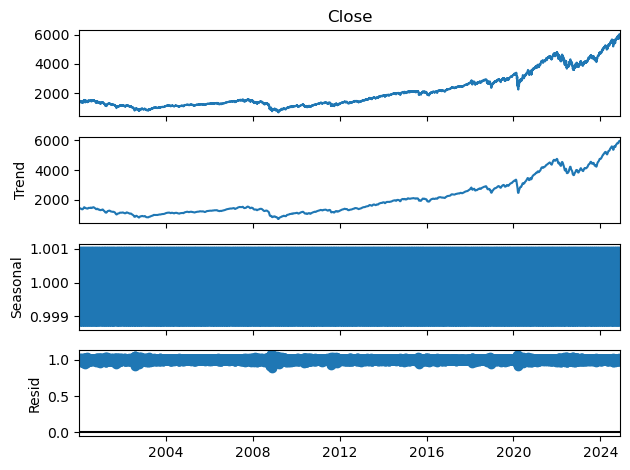

In [68]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(filtered_data['Close'], model='multiplicative', period=12)
decomposition.plot()
plt.show()

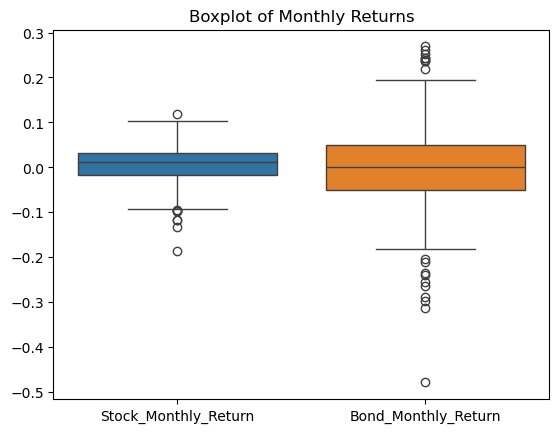

In [69]:
sns.boxplot(data=monthly_data[['Stock_Monthly_Return', 'Bond_Monthly_Return']])
plt.title('Boxplot of Monthly Returns')
plt.show()

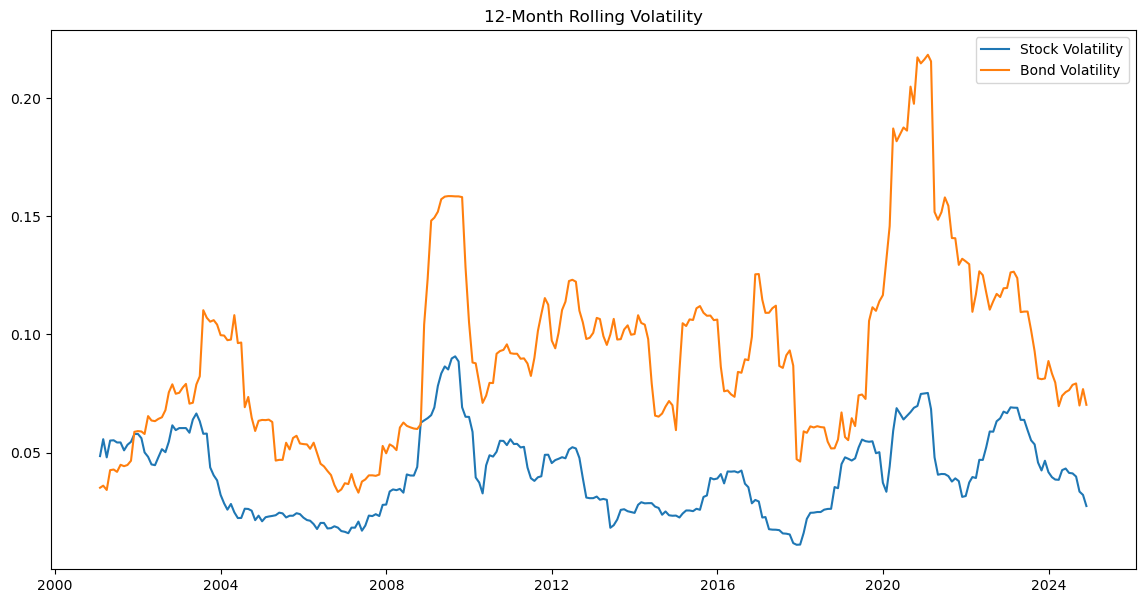

In [72]:
monthly_data['Stock_Rolling_Std'] = monthly_data['Stock_Monthly_Return'].rolling(window=12).std()
monthly_data['Bond_Rolling_Std'] = monthly_data['Bond_Monthly_Return'].rolling(window=12).std()

plt.figure(figsize=(14, 7))
plt.plot(monthly_data.index, monthly_data['Stock_Rolling_Std'], label='Stock Volatility')
plt.plot(monthly_data.index, monthly_data['Bond_Rolling_Std'], label='Bond Volatility')
plt.title('12-Month Rolling Volatility')
plt.legend()
plt.show()

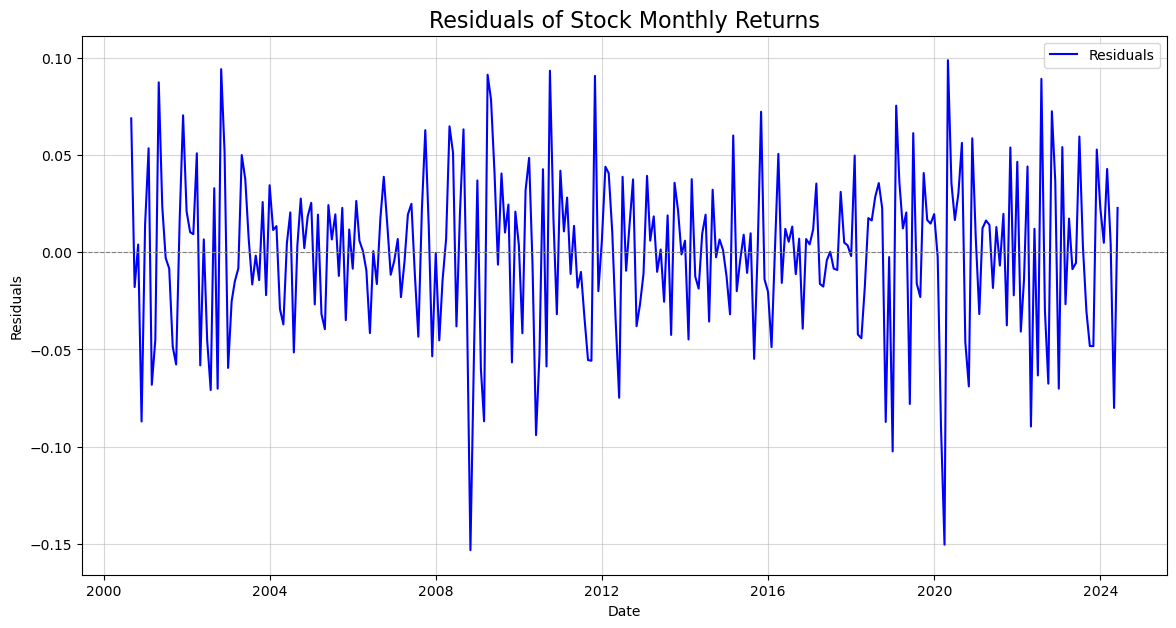

Residuals Descriptive Statistics:
count    286.000000
mean      -0.000040
std        0.040957
min       -0.153288
25%       -0.023066
50%        0.004335
75%        0.022870
max        0.098819
Name: resid, dtype: float64


In [74]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# 对股票月收益率进行时间序列分解（趋势、季节性、残差）
decomposition = seasonal_decompose(monthly_data['Stock_Monthly_Return'].dropna(), model='additive', period=12)

# 查看残差部分
residuals = decomposition.resid

# 绘制残差时间序列
plt.figure(figsize=(14, 7))
plt.plot(residuals, label='Residuals', color='blue')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.title('Residuals of Stock Monthly Returns', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

# 显示残差的描述性统计
print("Residuals Descriptive Statistics:")
print(residuals.describe())

In [76]:
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Durbin-Watson 检验
dw_stat = durbin_watson(residuals.dropna())
print(f"Durbin-Watson Statistic: {dw_stat:.3f}")

Durbin-Watson Statistic: 2.181


In [79]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress

# Ensure 'Date' is a regular column if it's the index
if 'Date' not in monthly_data.columns:
    monthly_data = monthly_data.reset_index()

# Ensure 'Date' is in datetime format
monthly_data['Date'] = pd.to_datetime(monthly_data['Date'], errors='coerce')

# Drop rows where date parsing failed
monthly_data = monthly_data.dropna(subset=['Date'])

# Define phase ranges
phases = {
    "Pre-Crisis": ('2006-01-01', '2007-12-31'),
    "Crisis": ('2008-01-01', '2009-12-31'),
    "Post-Crisis": ('2010-01-01', '2011-12-31')
}

# Iterate through each phase and fit a linear regression model
for phase, (start_date, end_date) in phases.items():
    # Filter data for the phase
    phase_data = monthly_data[
        (monthly_data['Date'] >= start_date) & (monthly_data['Date'] <= end_date)
    ]
    
    # Drop rows with missing values in relevant columns
    phase_data = phase_data.dropna(subset=['Stock_Monthly_Return', 'Bond_Monthly_Return'])

    # Check if data is sufficient
    if len(phase_data) < 2:  # At least two data points are needed
        print(f"{phase} Phase: Insufficient data to fit the regression model")
        print("-" * 50)
        continue

    # Independent and dependent variables
    X = phase_data['Bond_Monthly_Return'].values.reshape(-1, 1)
    y = phase_data['Stock_Monthly_Return'].values

    # Fit linear regression using sklearn
    model = LinearRegression()
    model.fit(X, y)
    r_squared = model.score(X, y)

    # Compute p-value and regression coefficients using scipy
    slope, intercept, r_value, p_value, std_err = linregress(
        phase_data['Bond_Monthly_Return'], phase_data['Stock_Monthly_Return']
    )

    # Print results
    print(f"{phase} Phase:")
    print(f"Regression Equation: Stock_Monthly_Return = {intercept:.4f} + {slope:.4f} * Bond_Monthly_Return")
    print(f"R² Value: {r_squared:.4f}")
    print(f"p-Value: {p_value:.4e}")
    print("-" * 50)

Pre-Crisis Phase:
Regression Equation: Stock_Monthly_Return = 0.0075 + 0.2204 * Bond_Monthly_Return
R² Value: 0.1803
p-Value: 3.8617e-02
--------------------------------------------------
Crisis Phase:
Regression Equation: Stock_Monthly_Return = -0.0114 + 0.0183 * Bond_Monthly_Return
R² Value: 0.0010
p-Value: 8.8210e-01
--------------------------------------------------
Post-Crisis Phase:
Regression Equation: Stock_Monthly_Return = 0.0173 + 0.4131 * Bond_Monthly_Return
R² Value: 0.6073
p-Value: 7.1967e-06
--------------------------------------------------


In [81]:
from statsmodels.tsa.ar_model import AutoReg

# Filter data for the 2008 financial crisis period
crisis_2008_data = monthly_data[
    (monthly_data['Date'] >= '2008-01-01') & (monthly_data['Date'] <= '2009-12-31')
].dropna(subset=['Stock_Monthly_Return', 'Bond_Monthly_Return'])

# Prepare data
stock_returns = crisis_2008_data['Stock_Monthly_Return']
bond_returns = crisis_2008_data['Bond_Monthly_Return']

# AR model for stock returns
stock_ar_model = AutoReg(stock_returns, lags=1).fit()
print("Stock Returns AR Model (During 2008 Financial Crisis):")
print(stock_ar_model.summary())

# AR model for bond returns
bond_ar_model = AutoReg(bond_returns, lags=1).fit()
print("\nBond Returns AR Model (During 2008 Financial Crisis):")
print(bond_ar_model.summary())

Stock Returns AR Model (During 2008 Financial Crisis):
                             AutoReg Model Results                              
Dep. Variable:     Stock_Monthly_Return   No. Observations:                   24
Model:                       AutoReg(1)   Log Likelihood                  30.898
Method:                 Conditional MLE   S.D. of innovations              0.063
Date:                  Sun, 08 Dec 2024   AIC                            -55.796
Time:                          17:02:26   BIC                            -52.390
Sample:                               1   HQIC                           -54.939
                                     24                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.0041      0.013     -0.306      0.760      -0.030       0.022
Stock_Monthly_Return.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [84]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress

# Ensure 'Date' is a regular column if it's the index
if 'Date' not in monthly_data.columns:
    monthly_data = monthly_data.reset_index()

# Ensure 'Date' is in datetime format
monthly_data['Date'] = pd.to_datetime(monthly_data['Date'], errors='coerce')

# Drop rows where date parsing failed
monthly_data = monthly_data.dropna(subset=['Date'])

# Define phase ranges
phases = {
    "Pre-Crisis (2019-2020)": ('2019-01-01', '2020-12-31'),
    "Crisis (2020-2021)": ('2020-01-01', '2021-12-31'),
    "Post-Crisis (2022-2023)": ('2022-01-01', '2023-12-31')
}

# Iterate through each phase and fit a linear regression model
for phase, (start_date, end_date) in phases.items():
    # Filter data for the phase
    phase_data = monthly_data[
        (monthly_data['Date'] >= start_date) & (monthly_data['Date'] <= end_date)
    ]
    
    # Drop rows with missing values in relevant columns
    phase_data = phase_data.dropna(subset=['Stock_Monthly_Return', 'Bond_Monthly_Return'])

    # Check if data is sufficient
    if len(phase_data) < 2:  # At least two data points are needed
        print(f"{phase}: Insufficient data to fit the regression model")
        print("-" * 50)
        continue

    # Independent and dependent variables
    X = phase_data['Bond_Monthly_Return'].values.reshape(-1, 1)
    y = phase_data['Stock_Monthly_Return'].values

    # Fit linear regression using sklearn
    model = LinearRegression()
    model.fit(X, y)
    r_squared = model.score(X, y)

    # Compute p-value and regression coefficients using scipy
    slope, intercept, r_value, p_value, std_err = linregress(
        phase_data['Bond_Monthly_Return'], phase_data['Stock_Monthly_Return']
    )

    # Print results
    print(f"{phase}:")
    print(f"Regression Equation: Stock_Monthly_Return = {intercept:.4f} + {slope:.4f} * Bond_Monthly_Return")
    print(f"R² Value: {r_squared:.4f}")
    print(f"p-Value: {p_value:.4e}")
    print("-" * 50)

Pre-Crisis (2019-2020):
Regression Equation: Stock_Monthly_Return = 0.0246 + 0.1742 * Bond_Monthly_Return
R² Value: 0.2627
p-Value: 1.0449e-02
--------------------------------------------------
Crisis (2020-2021):
Regression Equation: Stock_Monthly_Return = 0.0173 + 0.1160 * Bond_Monthly_Return
R² Value: 0.1407
p-Value: 7.0856e-02
--------------------------------------------------
Post-Crisis (2022-2023):
Regression Equation: Stock_Monthly_Return = 0.0134 + -0.3414 * Bond_Monthly_Return
R² Value: 0.4316
p-Value: 4.8767e-04
--------------------------------------------------


In [93]:
from statsmodels.tsa.ar_model import AutoReg

# Filter data for the 2020 pandemic period
pandemic_2020_data = monthly_data[
    (monthly_data['Date'] >= '2020-01-01') & (monthly_data['Date'] <= '2021-12-31')
].dropna(subset=['Stock_Monthly_Return', 'Bond_Monthly_Return'])

# Prepare data
stock_returns = pandemic_2020_data['Stock_Monthly_Return']
bond_returns = pandemic_2020_data['Bond_Monthly_Return']

# AR model for stock returns
stock_ar_model = AutoReg(stock_returns, lags=1).fit()
print("Stock Returns AR Model (During 2020 Pandemic Period):")
print(stock_ar_model.summary())

# AR model for bond returns
bond_ar_model = AutoReg(bond_returns, lags=1).fit()
print("\nBond Returns AR Model (During 2020 Pandemic Period):")
print(bond_ar_model.summary())

Stock Returns AR Model (During 2020 Pandemic Period):
                             AutoReg Model Results                              
Dep. Variable:     Stock_Monthly_Return   No. Observations:                   24
Model:                       AutoReg(1)   Log Likelihood                  33.554
Method:                 Conditional MLE   S.D. of innovations              0.056
Date:                  Sun, 08 Dec 2024   AIC                            -61.108
Time:                          17:03:36   BIC                            -57.701
Sample:                               1   HQIC                           -60.251
                                     24                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0173      0.012      1.424      0.155      -0.007       0.041
Stock_Monthly_Return.L

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# 最优资产配置

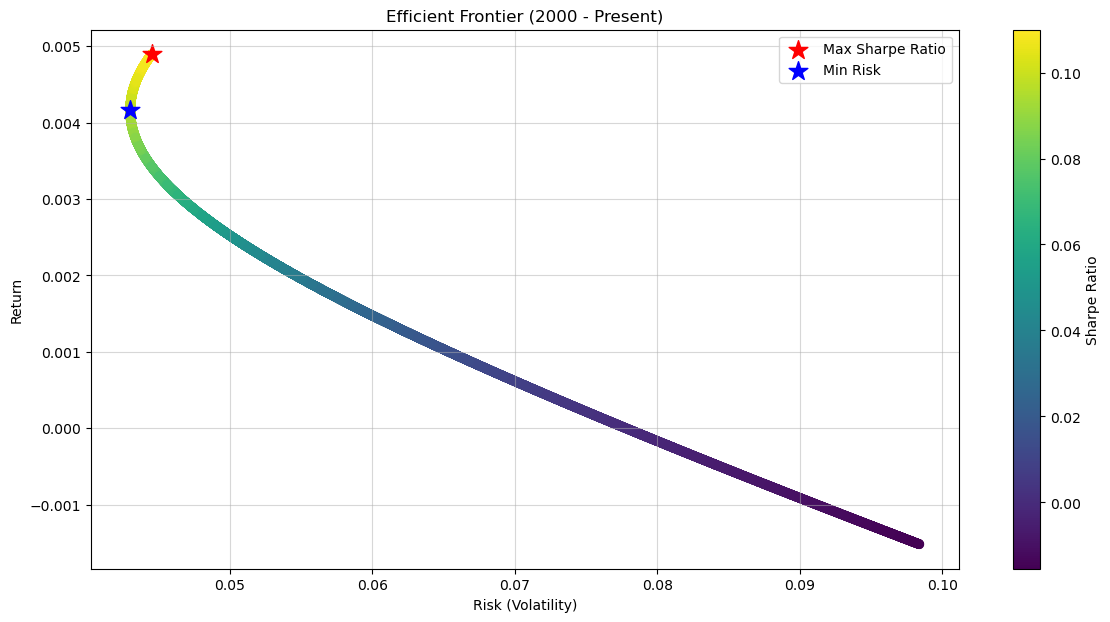

Maximum Sharpe Ratio Portfolio:
Return          0.004893
Risk            0.044504
Sharpe_Ratio    0.109956
Name: 8559, dtype: float64

Minimum Risk Portfolio:
Return          0.004157
Risk            0.043000
Sharpe_Ratio    0.096683
Name: 3408, dtype: float64


In [177]:
import numpy as np
import matplotlib.pyplot as plt

# 从2000年开始的数据
data_2000_onwards = monthly_data.loc['2000-01-01':]

# 平均收益率和协方差矩阵
mean_returns = data_2000_onwards[['Stock_Monthly_Return', 'Bond_Monthly_Return']].mean()
cov_matrix = data_2000_onwards[['Stock_Monthly_Return', 'Bond_Monthly_Return']].cov()

# 模拟不同权重的资产组合
num_portfolios = 10000
results = np.zeros((3, num_portfolios))

for i in range(num_portfolios):
    weights = np.random.random(2)
    weights /= np.sum(weights)
    
    # 组合收益率
    portfolio_return = np.dot(weights, mean_returns)
    
    # 组合风险（方差的平方根）
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    # 保存结果
    results[0, i] = portfolio_return
    results[1, i] = portfolio_risk
    results[2, i] = portfolio_return / portfolio_risk  # 夏普比率

# 转换为 DataFrame
portfolio_results = pd.DataFrame(results.T, columns=['Return', 'Risk', 'Sharpe_Ratio'])

# 找到最高夏普比率的组合
max_sharpe_idx = portfolio_results['Sharpe_Ratio'].idxmax()
max_sharpe_portfolio = portfolio_results.iloc[max_sharpe_idx]

# 找到最小风险的组合
min_risk_idx = portfolio_results['Risk'].idxmin()
min_risk_portfolio = portfolio_results.iloc[min_risk_idx]

# 绘制有效前沿
plt.figure(figsize=(14, 7))
plt.scatter(portfolio_results['Risk'], portfolio_results['Return'], c=portfolio_results['Sharpe_Ratio'], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(max_sharpe_portfolio['Risk'], max_sharpe_portfolio['Return'], color='red', marker='*', s=200, label='Max Sharpe Ratio')
plt.scatter(min_risk_portfolio['Risk'], min_risk_portfolio['Return'], color='blue', marker='*', s=200, label='Min Risk')
plt.title('Efficient Frontier (2000 - Present)')
plt.xlabel('Risk (Volatility)')
plt.ylabel('Return')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

# 输出关键结果
print("Maximum Sharpe Ratio Portfolio:")
print(max_sharpe_portfolio)

print("\nMinimum Risk Portfolio:")
print(min_risk_portfolio)

---